# Credit Card Fraud Detection (Classification)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [2]:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [3]:
credit = pd.read_csv('creditcard.csv')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
credit.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
credit['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
X = credit.drop(['Class'], 1).to_numpy()
y = credit['Class'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

C:\Users\Seneca\AppData\Local\Temp/ipykernel_18096/4172792951.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = credit.drop(['Class'], 1).to_numpy()


In [7]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

In [8]:
def run_sampler_batch(run_model, samplers = [], incROC = False):
    metrics = []
    conf_disps = []
    rocs = []
    
    # make sure there are samplers to run
    if(len(samplers) > 0):
        for sampler, name in samplers:
            # get samples
            
            X_train_re, y_train_re = sampler.fit_resample(X_train_s, y_train)
            
            # run model
            if(incROC):
                mets, conf_disp, roc = run_model(X_train_re, y_train_re, name)
                rocs.append(roc)
            else:
                mets, conf_disp = run_model(X_train_re, y_train_re, name)
            
            # store performance stats in lists
            metrics.append(mets)
            conf_disps.append(conf_disp)
   
    else: # run model with original scaled training data
        if(incROC):
            mets, conf_disp, roc = run_model(X_train_s, y_train, "No Sampling Method")
            rocs.append(roc)
        else:
            mets, conf_disp = run_model(X_train_s, y_train, "No Sampling Method")
        
        # store performance stats in lists
        metrics.append(mets)
        conf_disps.append(conf_disp)
    
    # return performance stats
    if(incROC):
        return metrics, conf_disps, rocs
    return metrics, conf_disps

In [9]:
def print_metrics(metrics):
    for item in metrics:
        print("*****************************************")
        print(item["name"])
        print("Accuracy Score: ", item["accuracy"])
        print("Precision: ", item["precision"])
        print("Recall: ", item["recall"])
        print("F1: ", item["f1"])
        print()

def plot_conf_disps(conf_disps):
    for item in conf_disps:
        print(item["name"])
        item["disp"].plot()
        plt.show()
        
def plot_rocs(rocs):
    for item in rocs:
        plt.plot(item["fpr"], item["tpr"])
        plt.title(item["name"])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        plt.show()

## Logistic Regression

In [10]:
def run_log_reg(X_tr_nn, y_tr_nn, name):
    print("RUNNING LOGISTIC REGRESSION CLASSIFIER ON DATA: ", name)
    log_reg = LogisticRegression(solver='lbfgs', random_state=42, max_iter=1000)
    
    log_reg = log_reg.fit(X_tr_nn, y_tr_nn)
    
    y_pred = log_reg.predict(X_test_s)
    # y_pred = np.where(y_pred > 0.5, 1, 0)

    # get metrics to be printed later
    metrics_rf = {"name": name, 
               "accuracy": accuracy_score(y_test, y_pred),
               "precision": precision_score(y_test, y_pred, zero_division=False),
               "recall": recall_score(y_test, y_pred),
               "f1": f1_score(y_test, y_pred),
              }
    
    # generate confusion matrix visualizations
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_disp_rf = {"name": name, 
                 "disp": ConfusionMatrixDisplay(conf_matrix)
                 }
    
    # get false and true positive rates to graph later
    
    y_scores = cross_val_predict(log_reg, X_test_s, y_test, cv=3, method="decision_function")
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
    roc_rf = {"name": name,
           "fpr": fpr,
           "tpr": tpr
          }
    
    return metrics_rf, conf_disp_rf, roc_rf

### Logistic regression without accounting for class imbalances

In [11]:
metrics, conf_disps, rocs = run_sampler_batch(run_model=run_log_reg, incROC=True)

RUNNING LOGISTIC REGRESSION CLASSIFIER ON DATA:  No Sampling Method


In [12]:
print_metrics(metrics)

*****************************************
No Sampling Method
Accuracy Score:  0.9992764956855735
Precision:  0.8715596330275229
Recall:  0.6375838926174496
F1:  0.7364341085271318



No Sampling Method


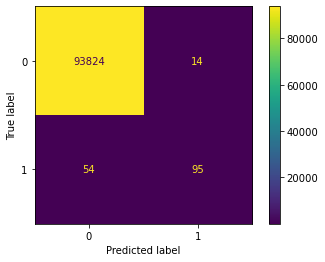

In [13]:
plot_conf_disps(conf_disps)

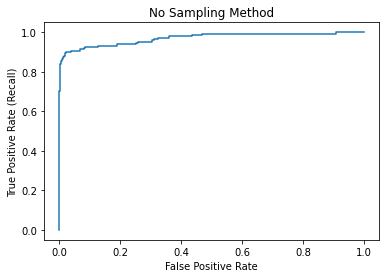

In [14]:
plot_rocs(rocs)

### Logistic Regression with Oversampling

In [15]:
over_samplers = [[RandomOverSampler(random_state=42), "RandomOverSampler"],
                 [SMOTE(random_state=42), "SMOTE"],
                 [ADASYN(random_state=42), "ADASYN"],
                 [BorderlineSMOTE(random_state=42), "BorderLineSMOTE"]
                ]

In [16]:
metrics, conf_disps, rocs = run_sampler_batch(run_model=run_log_reg, samplers=over_samplers, incROC=True)

RUNNING LOGISTIC REGRESSION CLASSIFIER ON DATA:  RandomOverSampler
RUNNING LOGISTIC REGRESSION CLASSIFIER ON DATA:  SMOTE
RUNNING LOGISTIC REGRESSION CLASSIFIER ON DATA:  ADASYN
RUNNING LOGISTIC REGRESSION CLASSIFIER ON DATA:  BorderLineSMOTE


In [17]:
print_metrics(metrics)

*****************************************
RandomOverSampler
Accuracy Score:  0.9728792279783375
Precision:  0.05089820359281437
Recall:  0.912751677852349
F1:  0.09641970932293513

*****************************************
SMOTE
Accuracy Score:  0.9721344441252514
Precision:  0.049927113702623906
Recall:  0.9194630872483222
F1:  0.0947113722779122

*****************************************
ADASYN
Accuracy Score:  0.9053805313500803
Precision:  0.015621537779747396
Recall:  0.9463087248322147
F1:  0.030735694822888286

*****************************************
BorderLineSMOTE
Accuracy Score:  0.9909774756083288
Precision:  0.13403141361256546
Recall:  0.8590604026845637
F1:  0.23188405797101452



RandomOverSampler


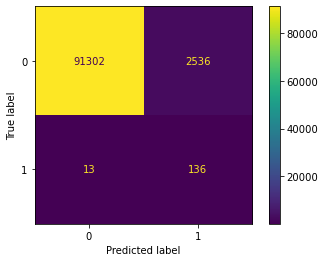

SMOTE


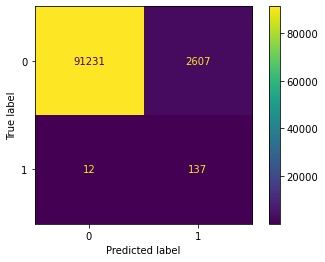

ADASYN


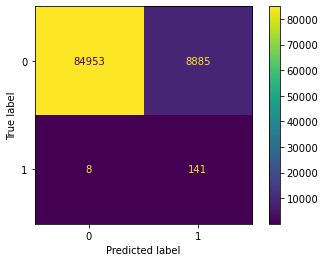

BorderLineSMOTE


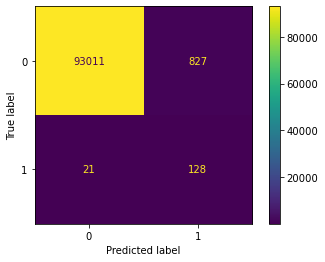

In [18]:
plot_conf_disps(conf_disps)

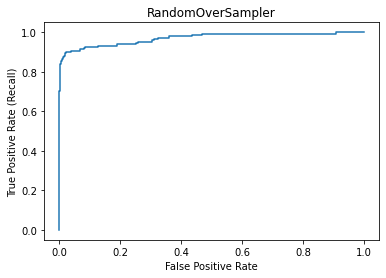

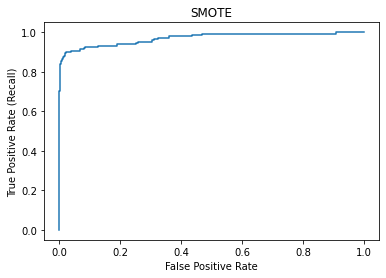

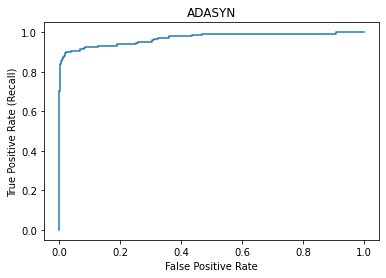

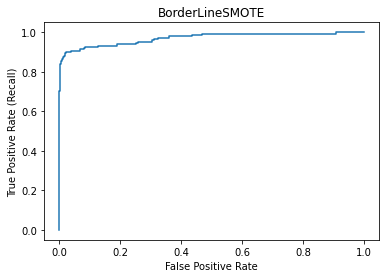

In [19]:
plot_rocs(rocs)

### Logistic Regression with Undersampling

In [20]:
under_samplers = [[RandomUnderSampler(random_state=42), "RandomUnderSampler"],
                 [NearMiss(), "NearMiss"]
                ]

In [21]:
metrics, conf_disps, rocs = run_sampler_batch(run_model=run_log_reg, samplers=under_samplers, incROC=True)

RUNNING LOGISTIC REGRESSION CLASSIFIER ON DATA:  RandomUnderSampler
RUNNING LOGISTIC REGRESSION CLASSIFIER ON DATA:  NearMiss


In [22]:
print_metrics(metrics)

*****************************************
RandomUnderSampler
Accuracy Score:  0.9584517007671274
Precision:  0.03422619047619048
Recall:  0.9261744966442953
F1:  0.06601291557043769

*****************************************
NearMiss
Accuracy Score:  0.585197952908381
Precision:  0.0034774604311028153
Recall:  0.912751677852349
F1:  0.006928524122471852



RandomUnderSampler


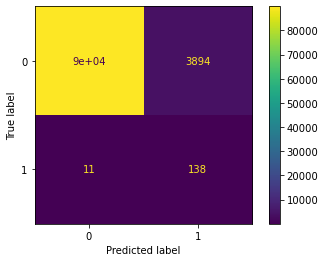

NearMiss


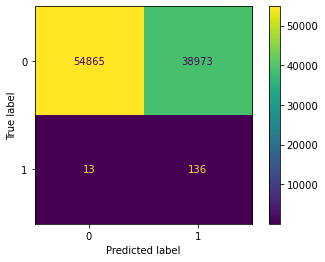

In [23]:
plot_conf_disps(conf_disps)

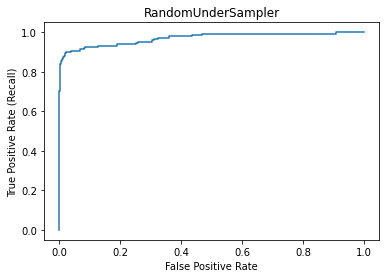

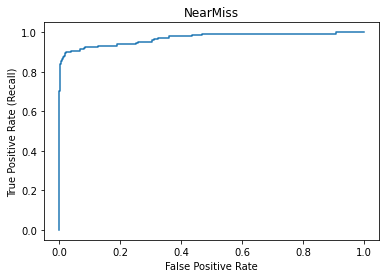

In [24]:
plot_rocs(rocs)

## Neural Network

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [26]:
np.shape(X_train_s[0])

(30,)

In [27]:
def run_nn(X_tr_nn, y_tr_nn, name):
    print("RUNNING NEURAL NETWORK ON DATA: ", name)
    classifier = Sequential()
    classifier.add(keras.layers.Dense(units=60, kernel_initializer='uniform', activation='tanh', input_dim=30))
    classifier.add(keras.layers.Dense(units=30, kernel_initializer='uniform', activation='tanh'))
    classifier.add(keras.layers.Dense(units=10, kernel_initializer='uniform', activation='tanh'))
    classifier.add(keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = classifier.fit(X_tr_nn, y_tr_nn, epochs=20, batch_size=10)
    
    y_pred = classifier.predict(X_test_s)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    # get metrics to be printed later
    metrics_nn = {"name": name, 
               "accuracy": accuracy_score(y_test, y_pred),
               "precision": precision_score(y_test, y_pred, zero_division=False),
               "recall": recall_score(y_test, y_pred),
               "f1": f1_score(y_test, y_pred),
              }
    
    # generate confusion matrix visualizations
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_disp_nn = {"name": name, 
                 "disp": ConfusionMatrixDisplay(conf_matrix)
                 }
    
    return metrics_nn, conf_disp_nn

### Neural Network without accounting for class imbalance

In [28]:
metrics, conf_disps = run_sampler_batch(run_nn)

RUNNING NEURAL NETWORK ON DATA:  No Sampling Method
Epoch 1/20
19082/19082 [==============================] - 20s 1ms/step - loss: 0.0091 - accuracy: 0.9991
Epoch 2/20
19082/19082 [==============================] - 20s 1ms/step - loss: 0.0040 - accuracy: 0.9993
Epoch 3/20
19082/19082 [==============================] - 21s 1ms/step - loss: 0.0035 - accuracy: 0.9994
Epoch 4/20
19082/19082 [==============================] - 21s 1ms/step - loss: 0.0034 - accuracy: 0.9993
Epoch 5/20
19082/19082 [==============================] - 22s 1ms/step - loss: 0.0032 - accuracy: 0.9993
Epoch 6/20
19082/19082 [==============================] - 23s 1ms/step - loss: 0.0031 - accuracy: 0.9993
Epoch 7/20
19082/19082 [==============================] - 24s 1ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 8/20
19082/19082 [==============================] - 23s 1ms/step - loss: 0.0028 - accuracy: 0.9994
Epoch 9/20
19082/19082 [==============================] - 23s 1ms/step - loss: 0.0027 - accuracy: 0.9994
Epo

In [29]:
print_metrics(metrics)

*****************************************
No Sampling Method
Accuracy Score:  0.9994041729175311
Precision:  0.803921568627451
Recall:  0.825503355704698
F1:  0.8145695364238411



No Sampling Method


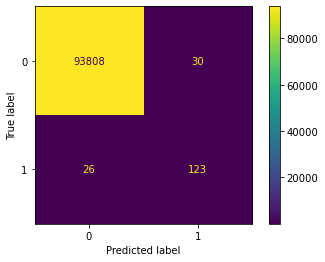

In [30]:
plot_conf_disps(conf_disps)

### Neural Network with Oversampling

In [31]:
over_samplers = [[RandomOverSampler(random_state=42), "RandomOverSampler"],
                 [SMOTE(random_state=42), "SMOTE"],
                 [ADASYN(random_state=42), "ADASYN"],
                 [BorderlineSMOTE(random_state=42), "BorderLineSMOTE"]
                ]

In [32]:
metrics, conf_disps = run_sampler_batch(run_nn, over_samplers)

RUNNING NEURAL NETWORK ON DATA:  RandomOverSampler
Epoch 1/20
38096/38096 [==============================] - 52s 1ms/step - loss: 0.0476 - accuracy: 0.9835
Epoch 2/20
38096/38096 [==============================] - 57s 1ms/step - loss: 0.0080 - accuracy: 0.9978
Epoch 3/20
38096/38096 [==============================] - 49s 1ms/step - loss: 0.0051 - accuracy: 0.9987
Epoch 4/20
38096/38096 [==============================] - 42s 1ms/step - loss: 0.0037 - accuracy: 0.9992
Epoch 5/20
38096/38096 [==============================] - 42s 1ms/step - loss: 0.0030 - accuracy: 0.9994
Epoch 6/20
38096/38096 [==============================] - 43s 1ms/step - loss: 0.0027 - accuracy: 0.9995
Epoch 7/20
38096/38096 [==============================] - 44s 1ms/step - loss: 0.0027 - accuracy: 0.9995
Epoch 8/20
38096/38096 [==============================] - 44s 1ms/step - loss: 0.0021 - accuracy: 0.9996
Epoch 9/20
38096/38096 [==============================] - 45s 1ms/step - loss: 0.0020 - accuracy: 0.9996
Epoc

38096/38096 [==============================] - 47s 1ms/step - loss: 0.0014 - accuracy: 0.9998
Epoch 17/20
38096/38096 [==============================] - 47s 1ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 18/20
38096/38096 [==============================] - 46s 1ms/step - loss: 0.0015 - accuracy: 0.9998
Epoch 19/20
38096/38096 [==============================] - 47s 1ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 20/20
38096/38096 [==============================] - 46s 1ms/step - loss: 0.0012 - accuracy: 0.9998


In [33]:
print_metrics(metrics)

*****************************************
RandomOverSampler
Accuracy Score:  0.9992020173002649
Precision:  0.7151162790697675
Recall:  0.825503355704698
F1:  0.7663551401869161

*****************************************
SMOTE
Accuracy Score:  0.9984572334471788
Precision:  0.5078740157480315
Recall:  0.8657718120805369
F1:  0.6401985111662531

*****************************************
ADASYN
Accuracy Score:  0.9989466628363497
Precision:  0.631578947368421
Recall:  0.8053691275167785
F1:  0.7079646017699115

*****************************************
BorderLineSMOTE
Accuracy Score:  0.9992764956855735
Precision:  0.7755102040816326
Recall:  0.7651006711409396
F1:  0.7702702702702703



RandomOverSampler


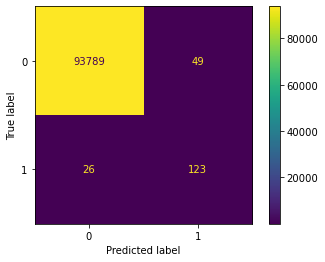

SMOTE


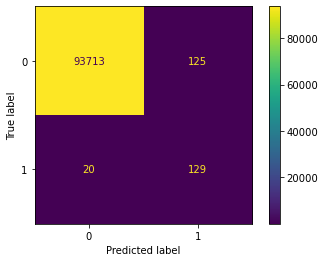

ADASYN


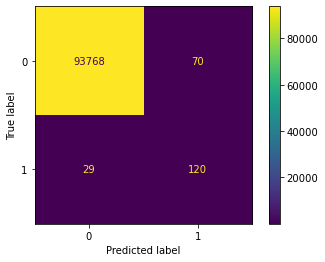

BorderLineSMOTE


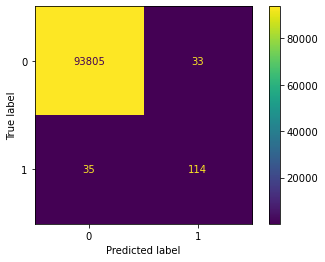

In [34]:
plot_conf_disps(conf_disps)

### Neural Network with Undersampling

In [35]:
under_samplers = [[RandomUnderSampler(random_state=42), "RandomUnderSampler"],
                 [NearMiss(), "NearMiss"]
                ]

In [36]:
metrics, conf_disps = run_sampler_batch(run_nn, under_samplers)

RUNNING NEURAL NETWORK ON DATA:  RandomUnderSampler
Epoch 1/20
69/69 [==============================] - 0s 854us/step - loss: 0.5887 - accuracy: 0.8630
Epoch 2/20
69/69 [==============================] - 0s 1ms/step - loss: 0.3145 - accuracy: 0.9344
Epoch 3/20
69/69 [==============================] - 0s 1ms/step - loss: 0.2301 - accuracy: 0.9402
Epoch 4/20
69/69 [==============================] - 0s 1ms/step - loss: 0.1945 - accuracy: 0.9461
Epoch 5/20
69/69 [==============================] - 0s 1ms/step - loss: 0.1725 - accuracy: 0.9577
Epoch 6/20
69/69 [==============================] - 0s 1ms/step - loss: 0.1654 - accuracy: 0.9548
Epoch 7/20
69/69 [==============================] - 0s 1ms/step - loss: 0.1586 - accuracy: 0.9563
Epoch 8/20
69/69 [==============================] - 0s 1ms/step - loss: 0.1538 - accuracy: 0.9548
Epoch 9/20
69/69 [==============================] - 0s 1ms/step - loss: 0.1458 - accuracy: 0.9534
Epoch 10/20
69/69 [==============================] - 0s 1ms/step

In [37]:
print_metrics(metrics)

*****************************************
RandomUnderSampler
Accuracy Score:  0.9410663176822327
Precision:  0.02435580656547829
Recall:  0.9261744966442953
F1:  0.047463456577815984

*****************************************
NearMiss
Accuracy Score:  0.5532254460723292
Precision:  0.003252920505271156
Recall:  0.9194630872483222
F1:  0.006482905477345322



RandomUnderSampler


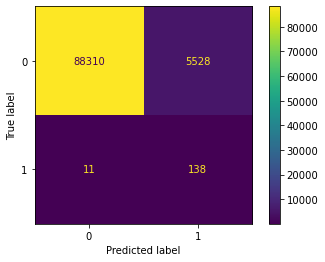

NearMiss


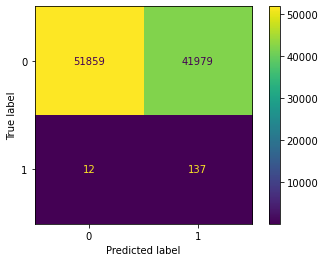

In [38]:
plot_conf_disps(conf_disps)

## Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
def run_rfc(X_tr_nn, y_tr_nn, name):
    print("RUNNING RANDOM FOREST CLASSIFIER ON DATA: ", name)
    rfc = RandomForestClassifier(random_state=42)
    
    rfc.fit(X_tr_nn, y_tr_nn)
    
    y_pred = rfc.predict(X_test_s)
    # y_pred = np.where(y_pred > 0.5, 1, 0)

    # get metrics to be printed later
    metrics_rf = {"name": name, 
               "accuracy": accuracy_score(y_test, y_pred),
               "precision": precision_score(y_test, y_pred, zero_division=False),
               "recall": recall_score(y_test, y_pred),
               "f1": f1_score(y_test, y_pred),
              }
    
    # generate confusion matrix visualizations
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_disp_rf = {"name": name, 
                 "disp": ConfusionMatrixDisplay(conf_matrix)
                 }
    
    # get false and true positive rates to graph later
    
    y_scores = cross_val_predict(rfc, X_test_s, y_test, cv=3)
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
    roc_rf = {"name": name,
           "fpr": fpr,
           "tpr": tpr
          }
    
    return metrics_rf, conf_disp_rf, roc_rf

In [41]:
metrics, conf_disps, rocs = run_sampler_batch(run_model=run_rfc, incROC=True)

RUNNING RANDOM FOREST CLASSIFIER ON DATA:  No Sampling Method


In [42]:
print_metrics(metrics)

*****************************************
No Sampling Method
Accuracy Score:  0.9995956887654676
Precision:  0.937007874015748
Recall:  0.7986577181208053
F1:  0.8623188405797101



No Sampling Method


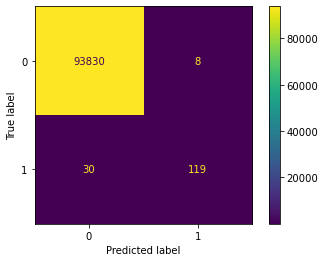

In [43]:
plot_conf_disps(conf_disps)

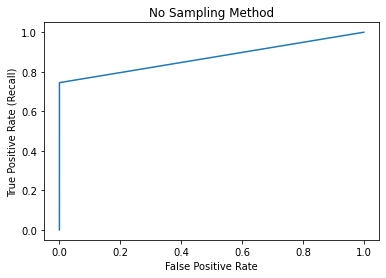

In [44]:
plot_rocs(rocs)

### Random Forest Classifier with Oversampling

In [45]:
over_samplers = [[RandomOverSampler(random_state=42), "RandomOverSampler"],
                 [SMOTE(random_state=42), "SMOTE"],
                 [ADASYN(random_state=42), "ADASYN"],
                 [BorderlineSMOTE(random_state=42), "BorderLineSMOTE"]
                ]

In [46]:
metrics, conf_disps, rocs = run_sampler_batch(run_model=run_rfc, samplers=over_samplers, incROC=True)

RUNNING RANDOM FOREST CLASSIFIER ON DATA:  RandomOverSampler
RUNNING RANDOM FOREST CLASSIFIER ON DATA:  SMOTE
RUNNING RANDOM FOREST CLASSIFIER ON DATA:  ADASYN
RUNNING RANDOM FOREST CLASSIFIER ON DATA:  BorderLineSMOTE


In [47]:
print_metrics(metrics)

*****************************************
RandomOverSampler
Accuracy Score:  0.9996488876121166
Precision:  0.9603174603174603
Recall:  0.8120805369127517
F1:  0.8800000000000001

*****************************************
SMOTE
Accuracy Score:  0.999574409226808
Precision:  0.8707482993197279
Recall:  0.8590604026845637
F1:  0.8648648648648649

*****************************************
ADASYN
Accuracy Score:  0.9995105706108292
Precision:  0.8551724137931035
Recall:  0.8322147651006712
F1:  0.8435374149659864

*****************************************
BorderLineSMOTE
Accuracy Score:  0.9995956887654676
Precision:  0.9302325581395349
Recall:  0.8053691275167785
F1:  0.8633093525179855



RandomOverSampler


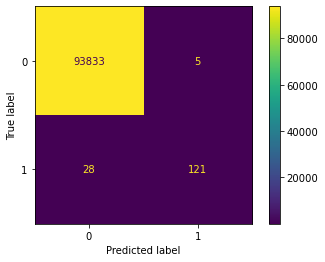

SMOTE


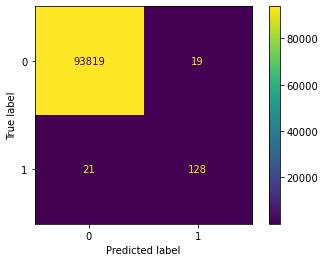

ADASYN


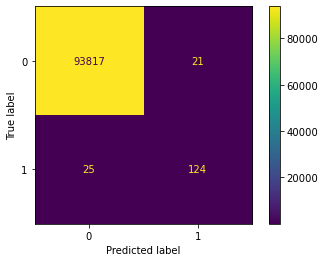

BorderLineSMOTE


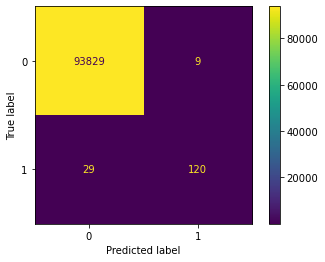

In [48]:
plot_conf_disps(conf_disps)

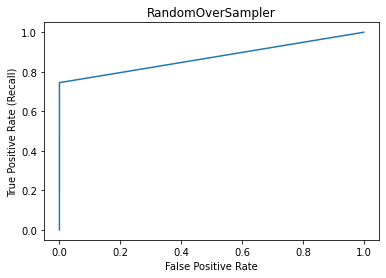

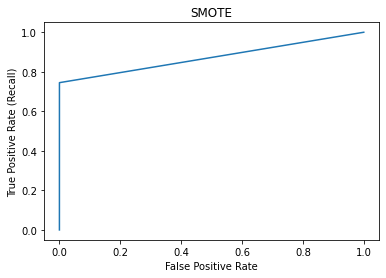

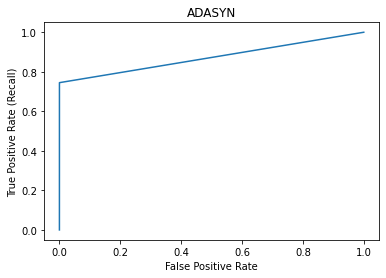

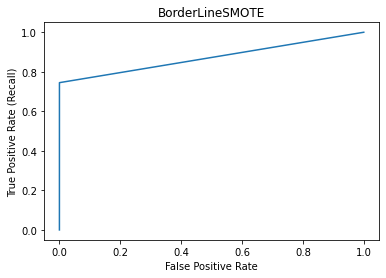

In [49]:
plot_rocs(rocs)

### Random Forest Classifier with Undersampling

In [50]:
under_samplers = [[RandomUnderSampler(random_state=42), "RandomUnderSampler"],
                 [NearMiss(), "NearMiss"]
                ]

In [51]:
metrics, conf_disps, rocs = run_sampler_batch(run_model=run_rfc, samplers=under_samplers, incROC=True)

RUNNING RANDOM FOREST CLASSIFIER ON DATA:  RandomUnderSampler
RUNNING RANDOM FOREST CLASSIFIER ON DATA:  NearMiss


In [52]:
print_metrics(metrics)

*****************************************
RandomUnderSampler
Accuracy Score:  0.967559343313437
Precision:  0.04373820012586532
Recall:  0.9328859060402684
F1:  0.08355876164712954

*****************************************
NearMiss
Accuracy Score:  0.0606573249491951
Precision:  0.0016623129897886488
Recall:  0.9865771812080537
F1:  0.0033190336419056223



RandomUnderSampler


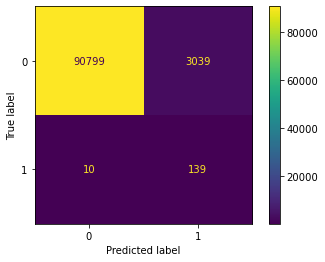

NearMiss


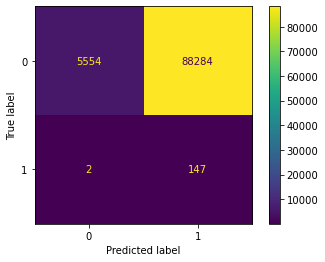

In [53]:
plot_conf_disps(conf_disps)

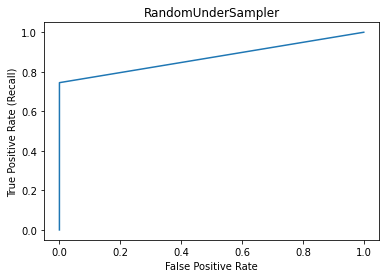

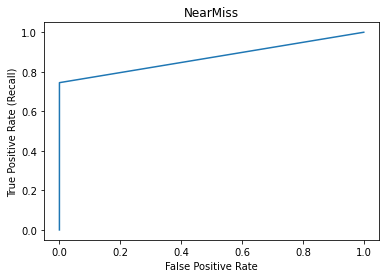

In [54]:
plot_rocs(rocs)